In [129]:
import numpy as np
import pickle as pkl
import json
import torch
import librosa
import os
import sys
import cv2
import shutil
from matplotlib import pyplot as plt
import csv
from datetime import datetime
import soundfile as sf
# import utility functions
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Desktop/openpose/python/')
# sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox")

from Geometry_Util import rotation_angles_frome_positions


In [11]:
def get_valid_shots(shots, fps, shot_length_mininmum=5):
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for shot in shots:
        start = shot[0]
        end = shot[1]
    # load the input shots range
    valid_shots_time, valid_shots_frames = [], []
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for i in range(len(shots)):
        start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        end = datetime.strptime(shots[i][1], '%H:%M:%S.%f').timestamp()
        if (end-start) >= shot_length_mininmum:
            start_t = start-t0
            end_t = end - t0
            valid_shots_time.append([start-t0, end-t0])
            valid_shots_frames.append([int(np.round(start_t*fps)), int(np.round(end_t*fps))])

    return valid_shots_time, valid_shots_frames

def load_head_and_gaze_angles(all_gaze_data, all_head_data):

    # head data
    head_angle_data = all_head_data["HEAD"]
    head_rotmat_per_frame = head_angle_data["ROTMAT"]
    head_bbox_per_frame = all_head_data["BBOX"] # we are not using but having it here is nice
    head_angle_per_frame = []
    neutral_position = np.array([0, 0, 100])
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position
        head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
    head_angle_per_frame = np.array(head_angle_per_frame)
    # getting rotation angle in z direction
    neutral_position2 = np.array([0, 100, 0])
    head_angle_z_per_frame = []
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position2
        pos = np.array([pos[1], pos[2], pos[0]])
        head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
    head_angle_xy_per_frame = np.array(head_angle_per_frame)
    head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
    head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

    # getting gaze data
    gaze_angle_data = all_gaze_data["RAW_GAZE"]
    gaze_angle_per_frame = gaze_angle_data["EULER"]
    gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
    blinks = all_head_data["BLINKS"]
    gaze_vec = np.array([0, 0, 100])
    eye_angle_per_frame = []
    for i in range(0, gaze_rotmat_per_frame.shape[0]):
        eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
        eye_line = eye_line / eye_line[2] * 100
        eye_angle_per_frame.append(eye_line)
    eye_angle_per_frame = np.array(eye_angle_per_frame)
    eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])
    return eye_angle_per_frame, head_angle_per_frame

# INPUT block

In [8]:
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
output_folder = "/Volumes/EVAN_DISK/MASC/shot_processed_dataset/"

# Make Directory Structure

In [ ]:
# First Deal with the output folder structures:
# remove everything in the output folder
try:
    os.mkdir(output_folder)
except:
    shutil.rmtree(output_folder)
    os.mkdir(output_folder)
os.mkdir(os.path.join(output_folder, "audio"))
os.mkdir(os.path.join(output_folder, "gaze"))
os.mkdir(os.path.join(output_folder, "head"))
os.mkdir(os.path.join(output_folder, "blinks"))

In [9]:
# generate metadata file
video_list_path = os.path.join(*[input_folder, "video"])
video_list = os.listdir(video_list_path)
all_metadata = {}
for video in video_list:
    if video[0:2] != "._" and video != "." and video != "..":
        cap = cv2.VideoCapture(os.path.join(*[video_list_path, video]))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        metadata = {"fps": fps,
                    "width": width, 
                    "height": height,
                    "frame_count": frame_count}
        all_metadata[video] = metadata
video_metadata_path = os.path.join(*[input_folder, "local_metadata.json"])
json.dump(all_metadata, open(video_metadata_path, "w"))

In [10]:
# obtain all the file_paths
video_metadata_path = os.path.join(*[input_folder, "local_metadata.json"])
video_metadatas = json.load(open(video_metadata_path))
video_names = list(video_metadatas.keys())

# Process All Files

In [149]:
metadata = {}
output_file_names = []
for i in range(0, len(video_names)):
    print("currently on video {}, {}".format(i, video_names[i]))
    TESTING = True
    # load the data for one video
    file_name_video = video_names[i]
    file_name = file_name_video.split(".")[0]
    metadata = video_metadatas[file_name_video]
    fps = metadata["fps"]

    # get file_paths
    audio_path = os.path.join(*[input_folder, "audio", file_name + ".wav"])
    # annotation
    gaze_direction_path = os.path.join(*[input_folder, "ETHGaze-Mod", file_name+".pkl"])
    head_direction_path = os.path.join(*[input_folder, "pose", file_name+".pkl"])
    diarization_path = os.path.join(*[input_folder, "tracklets", file_name+"_Speakers.json"])
    # shots
    shot_path = os.path.join(*[input_folder, "shots", file_name, "shot_cuts.json"])
    try:
        shots = json.load(open(shot_path))["shots"]
    except:
        shot_path = os.path.join(*[input_folder, "shots", file_name, file_name, "shot_cuts.json"])
        shots = json.load(open(shot_path))["shots"]
    # video
    all_gaze_data = pkl.load(open(gaze_direction_path, "rb"))
    all_head_data = pkl.load(open(head_direction_path, "rb"))
    gaze, neck = load_head_and_gaze_angles(all_gaze_data, all_head_data) # each one is of shape [N, 2] (the two angles are asimuth)
    blinks = all_head_data["BLINKS"] # of shapa [N, ], 1 = eye close, 0 = eye open

    # audio
    try:
        audio, sr = librosa.load(str(audio_path))
    except:
        print("failed for video: {}".format(i))
        continue
    speaker = json.load(open(diarization_path))["aligned"] # {speaker_id: [{"start": t, "end": t, "start_frame":frame, "end_frame":frame}]}

    # obtain the valid shots for this 
    valid_shots_time, valid_shots_frame = get_valid_shots(shots, fps, 5)

    # all the annotation data
    gazes_per_shot = []
    head_per_shot = []
    blink_per_shot = []
    for j in range(0, len(valid_shots_time)):
        time_range = valid_shots_time[j]
        frame_range = valid_shots_frame[j]
        gaze_in_shot = gaze[frame_range[0]:frame_range[1]]
        gazes_per_shot.append(gaze_in_shot)
        head_in_shot = neck[frame_range[0]:frame_range[1]]
        head_per_shot.append(head_in_shot)
        blink_in_shot = blinks[frame_range[0]:frame_range[1]]
        blink_per_shot.append(blink_in_shot)
        # do stuff to them here

    # identify the speaker in each shot
    speaker_id_per_shot = []
    speaker_ids = list(speaker.keys())
    auds = []
    if len(speaker_ids) == 0:
        for j in range(0, len(valid_shots_time)):
            # get the duration of the shot
            shot_range_time = valid_shots_time[j]
            shot_range_frames = valid_shots_frame[j]
            # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
            audio_start = int(shot_range_time[0] * sr)
            audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
            audio_of_shot = audio[audio_start:audio_end]
            on_screen_bitmap = np.ones(audio_of_shot.shape)
            off_screen_bitmap = np.zeros(audio_of_shot.shape)
            audio_on_screen = audio_of_shot * on_screen_bitmap
            audio_off_screen = audio_of_shot * off_screen_bitmap
            auds.append([audio_on_screen, audio_off_screen])
    elif len(speaker_ids) > 0:
        for j in range(0, len(valid_shots_time)):
            valid_shot_turn = valid_shots_frame[j]
            # create list to store the percentage overlap between the speaker's turn and the current shot
            speaker_overlaps = []
            for id in range(0, len(speaker_ids)):
                speaker_overlaps.append(0)
            # iterate through each speaker to find their overlap
            for id in range(0, len(speaker_ids)):
                speaker_activities = speaker[speaker_ids[id]]
                # iterate through each speech to sum up the overlapp
                for turn in range(0, len(speaker_activities)):
                    speech_interval = [speaker_activities[turn]["start_frame"], speaker_activities[turn]["end_frame"]]
                    # find overlapp
                    if np.maximum(speech_interval[0], valid_shot_turn[0]) <= np.minimum(speech_interval[1], valid_shot_turn[1]):
                        speaker_overlaps[id] = speaker_overlaps[id] + 1
            speaker_id_per_shot.append(speaker_ids[np.argmax(speaker_overlaps)])

        # parse audio for each shot (2 audio per shot)
        t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
        # start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        for j in range(0, len(valid_shots_time)):
            # get the duration of the shot
            shot_range_time = valid_shots_time[j]
            shot_range_frames = valid_shots_frame[j]
            # get the speaker activity of the speaker 
            speaker_activity = speaker[speaker_id_per_shot[j]]
            # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
            audio_start = int(shot_range_time[0] * sr)
            audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
            audio_of_shot = audio[audio_start:audio_end]
            on_screen_bitmap = np.zeros(audio_of_shot.shape)
            off_screen_bitmap = np.ones(audio_of_shot.shape)
            
            # parse the audio to get a bitmap of speech turn 
            for interval_i in range(0,len(speaker_activity)):
                # get the start and end of the current speaker turn
                turn_start = speaker_activity[interval_i]["start"]
                turn_end = speaker_activity[interval_i]["end"]
                # turn it into numbers, and make sure that 0 is the start of the shot not the video
                turn_start = datetime.strptime(turn_start, '%H:%M:%S.%f').timestamp() - t0
                turn_end = datetime.strptime(turn_end, '%H:%M:%S.%f').timestamp() - t0
                # get the same thing in frames
                turn_start_frame = int(turn_start * sr) - audio_start
                turn_end_frame = int(turn_end * sr) - audio_start
                on_screen_bitmap[turn_start_frame:turn_end_frame] = on_screen_bitmap[turn_start_frame:turn_end_frame] + 1
            off_screen_bitmap = off_screen_bitmap - on_screen_bitmap
            audio_on_screen = audio_of_shot * on_screen_bitmap
            audio_off_screen = audio_of_shot * off_screen_bitmap
            auds.append([audio_on_screen, audio_off_screen])

    for j in range(0, len(auds)):
        output_audio_onscreen_path = os.path.join(*[output_folder, "audio", file_name+"_{}_{}.wav".format(j, 0)]) 
        output_audio_offscreen_path = os.path.join(*[output_folder, "audio", file_name+"_{}_{}.wav".format(j, 1)]) 
        output_gaze_path = os.path.join(*[output_folder, "gaze", file_name+"_{}.pkl".format(j)]) 
        output_head_path = os.path.join(*[output_folder, "head", file_name+"_{}.pkl".format(j)]) 
        output_blinks_path = os.path.join(*[output_folder, "blinks", file_name+"_{}.pkl".format(j)]) 
        # annotation files
        pkl.dump(gazes_per_shot[j], open(output_gaze_path,  "wb"))
        pkl.dump(head_per_shot[j], open(output_head_path,  "wb"))
        pkl.dump(blink_per_shot[j], open(output_blinks_path,  "wb"))
        sf.write(output_audio_onscreen_path, auds[j][0], sr)
        sf.write(output_audio_offscreen_path, auds[j][1], sr)
        output_file_names.append(file_name+"_{}".format(j))
output_path = os.path.join(output_folder, "metadata.csv")
with open(output_path, mode='w', newline='\n') as csv_file:
    writer = csv.writer(csv_file)
    for name in output_file_names:
        writer.writerow([name])

currently on video 38, Stranger Things’ Dacre Montgomery’s Insane _Billy_ Audition Tape ｜ GQ.mp4
currently on video 39, Amber Pursey, Self- tape.mp4
currently on video 40, Neda Ghassemi- Self Tape Demo Reel.mp4
currently on video 41, Self-tape.mp4
currently on video 42, Libby Lee, Self Tape Reel (2021).mp4
currently on video 43, Self-Tape Audition Sample, ＂Hallmark＂ Christmas Film Scene： Veterinarian.mp4
currently on video 44, Self-Tape Example 48 Hour Film Festival ｜ How to do a self tape audition How to book your next movie.mp4
currently on video 45, 3 Minute Audition Monologue From Search Party ｜ Day 24 of 31 Self Tape Challenge.mp4
currently on video 46, SHERRY HSU - Self Tape.mp4
currently on video 47, Self Tape ｜ Viola_s ＂I left no ring with her＂ monologue ｜ Twelfth Night.mp4
currently on video 48, Self-Tape Audition Reel 2022.mp4
currently on video 49, TV Audition Scene Day 30 of 31 Self-Tape Challenge.mp4
currently on video 50, Self Tape - Elaine Morillo - Undisclosed Role (RAY

/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


currently on video 57, CMTC 2019 - Child 4-11 Self-Tape Competition Winner.mp4
currently on video 58, NicholasZoto  REEL.mp4
currently on video 59, Commercial Self Tape - People Store.mp4
currently on video 60, Self-Tape Audition Example Tasmania ｜ How to Get an Agent in Hollywood and Los Angeles ｜ Slate.mp4
currently on video 61, Emily Owens - Acting Selftape Reel.mp4
currently on video 62, Self Tape Reel.mp4
currently on video 63, Self tape 4⧸16.mp4
currently on video 64, Acting Self Tape Audition Example - Resentful Daughter.mp4
currently on video 65, Self-Tape Audition.mp4
currently on video 66, Lilly Niehaus Self Tape Reel.mp4
currently on video 67, My Audition Tape for The National Youth Theatre 2020 - Great News Today!!.mp4
currently on video 68, SELF TAPE DEMO REEL- Lillian Johnson.mp4
currently on video 69, IP-1110 WHEELER Self-Tape Cleo.mp4
currently on video 70, Acting self tape 1.mp4
currently on video 71, Madelaine Petsch audition for The Prom.mp4
currently on video 72, CL

In [160]:
metadata = {}
output_file_names = []
for i in [19, 30, 55, 78, 108]:
    print("currently on video {}, {}".format(i, video_names[i]))
    TESTING = True
    # load the data for one video
    file_name_video = video_names[i]
    file_name = file_name_video.split(".")[0]
    file_name = "".join(file_name_video.split(".")[:-2])
    metadata = video_metadatas[file_name_video]
    fps = metadata["fps"]

    # get file_paths
    audio_path = os.path.join(*[input_folder, "audio", file_name + ".wav"])
    # annotation
    gaze_direction_path = os.path.join(*[input_folder, "ETHGaze-Mod", file_name+".pkl"])
    head_direction_path = os.path.join(*[input_folder, "pose", file_name+".pkl"])
    diarization_path = os.path.join(*[input_folder, "tracklets", file_name+"_Speakers.json"])
    # shots
    shot_path = os.path.join(*[input_folder, "shots", file_name, "shot_cuts.json"])
    try:
        shots = json.load(open(shot_path))["shots"]
    except:
        shot_path = os.path.join(*[input_folder, "shots", file_name, file_name, "shot_cuts.json"])
        shots = json.load(open(shot_path))["shots"]
    # video
    all_gaze_data = pkl.load(open(gaze_direction_path, "rb"))
    all_head_data = pkl.load(open(head_direction_path, "rb"))
    gaze, neck = load_head_and_gaze_angles(all_gaze_data, all_head_data) # each one is of shape [N, 2] (the two angles are asimuth)
    blinks = all_head_data["BLINKS"] # of shapa [N, ], 1 = eye close, 0 = eye open

    # audio
    print(audio_path)
    if os.path.isfile(str(audio_path)):
        print('File exists')
    else:
        print('File does not exist')
    audio, sr = librosa.load(str(audio_path))
    speaker = json.load(open(diarization_path))["aligned"] # {speaker_id: [{"start": t, "end": t, "start_frame":frame, "end_frame":frame}]}

    # obtain the valid shots for this 
    valid_shots_time, valid_shots_frame = get_valid_shots(shots, fps, 5)

    # all the annotation data
    gazes_per_shot = []
    head_per_shot = []
    blink_per_shot = []
    for j in range(0, len(valid_shots_time)):
        time_range = valid_shots_time[j]
        frame_range = valid_shots_frame[j]
        gaze_in_shot = gaze[frame_range[0]:frame_range[1]]
        gazes_per_shot.append(gaze_in_shot)
        head_in_shot = neck[frame_range[0]:frame_range[1]]
        head_per_shot.append(head_in_shot)
        blink_in_shot = blinks[frame_range[0]:frame_range[1]]
        blink_per_shot.append(blink_in_shot)
        # do stuff to them here

    # identify the speaker in each shot
    speaker_id_per_shot = []
    speaker_ids = list(speaker.keys())
    auds = []
    if len(speaker_ids) == 0:
        for j in range(0, len(valid_shots_time)):
            # get the duration of the shot
            shot_range_time = valid_shots_time[j]
            shot_range_frames = valid_shots_frame[j]
            # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
            audio_start = int(shot_range_time[0] * sr)
            audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
            audio_of_shot = audio[audio_start:audio_end]
            on_screen_bitmap = np.ones(audio_of_shot.shape)
            off_screen_bitmap = np.zeros(audio_of_shot.shape)
            audio_on_screen = audio_of_shot * on_screen_bitmap
            audio_off_screen = audio_of_shot * off_screen_bitmap
            auds.append([audio_on_screen, audio_off_screen])
    elif len(speaker_ids) > 0:
        for j in range(0, len(valid_shots_time)):
            valid_shot_turn = valid_shots_frame[j]
            # create list to store the percentage overlap between the speaker's turn and the current shot
            speaker_overlaps = []
            for id in range(0, len(speaker_ids)):
                speaker_overlaps.append(0)
            # iterate through each speaker to find their overlap
            for id in range(0, len(speaker_ids)):
                speaker_activities = speaker[speaker_ids[id]]
                # iterate through each speech to sum up the overlapp
                for turn in range(0, len(speaker_activities)):
                    speech_interval = [speaker_activities[turn]["start_frame"], speaker_activities[turn]["end_frame"]]
                    # find overlapp
                    if np.maximum(speech_interval[0], valid_shot_turn[0]) <= np.minimum(speech_interval[1], valid_shot_turn[1]):
                        speaker_overlaps[id] = speaker_overlaps[id] + 1
            speaker_id_per_shot.append(speaker_ids[np.argmax(speaker_overlaps)])

        # parse audio for each shot (2 audio per shot)
        t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
        # start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        for j in range(0, len(valid_shots_time)):
            # get the duration of the shot
            shot_range_time = valid_shots_time[j]
            shot_range_frames = valid_shots_frame[j]
            # get the speaker activity of the speaker 
            speaker_activity = speaker[speaker_id_per_shot[j]]
            # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
            audio_start = int(shot_range_time[0] * sr)
            audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
            audio_of_shot = audio[audio_start:audio_end]
            on_screen_bitmap = np.zeros(audio_of_shot.shape)
            off_screen_bitmap = np.ones(audio_of_shot.shape)
            
            # parse the audio to get a bitmap of speech turn 
            for interval_i in range(0,len(speaker_activity)):
                # get the start and end of the current speaker turn
                turn_start = speaker_activity[interval_i]["start"]
                turn_end = speaker_activity[interval_i]["end"]
                # turn it into numbers, and make sure that 0 is the start of the shot not the video
                turn_start = datetime.strptime(turn_start, '%H:%M:%S.%f').timestamp() - t0
                turn_end = datetime.strptime(turn_end, '%H:%M:%S.%f').timestamp() - t0
                # get the same thing in frames
                turn_start_frame = int(turn_start * sr) - audio_start
                turn_end_frame = int(turn_end * sr) - audio_start
                on_screen_bitmap[turn_start_frame:turn_end_frame] = on_screen_bitmap[turn_start_frame:turn_end_frame] + 1
            off_screen_bitmap = off_screen_bitmap - on_screen_bitmap
            audio_on_screen = audio_of_shot * on_screen_bitmap
            audio_off_screen = audio_of_shot * off_screen_bitmap
            auds.append([audio_on_screen, audio_off_screen])

    for j in range(0, len(auds)):
        output_audio_onscreen_path = os.path.join(*[output_folder, "audio", file_name+"_{}_{}.wav".format(j, 0)]) 
        output_audio_offscreen_path = os.path.join(*[output_folder, "audio", file_name+"_{}_{}.wav".format(j, 1)]) 
        output_gaze_path = os.path.join(*[output_folder, "gaze", file_name+"_{}.pkl".format(j)]) 
        output_head_path = os.path.join(*[output_folder, "head", file_name+"_{}.pkl".format(j)]) 
        output_blinks_path = os.path.join(*[output_folder, "blinks", file_name+"_{}.pkl".format(j)]) 
        # annotation files
        pkl.dump(gazes_per_shot[j], open(output_gaze_path,  "wb"))
        pkl.dump(head_per_shot[j], open(output_head_path,  "wb"))
        pkl.dump(blink_per_shot[j], open(output_blinks_path,  "wb"))
        sf.write(output_audio_onscreen_path, auds[j][0], sr)
        sf.write(output_audio_offscreen_path, auds[j][1], sr)
        output_file_names.append(file_name+"_{}".format(j))
output_path = os.path.join(output_folder, "metadata.csv")
with open(output_path, mode='w', newline='\n') as csv_file:
    writer = csv.writer(csv_file)
    for name in output_file_names:
        writer.writerow([name])

currently on video 19, Self Tape Audition ＂Amos＂ in ＂My Brothers Keeper＂.mp4


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/shots/shot_cuts.json'

In [162]:
for i in [19, 30, 55, 78, 108]:
    file_name_video = video_names[i]
    print(file_name_video)

Self Tape Audition ＂Amos＂ in ＂My Brothers Keeper＂.mp4
Dacre Montgomery - Audition Tape.mp4
SELF TAPE Role： Malcolm Wyatt by Anthony Mark Mancini.mp4
Hugh Laurie - House MD, Audition Tape.mp4
Anthony J Tremé - ＂ Driver Ed＂ - Role： Clay   (self-tape audition).mp4


# Testing with One File

## Processing one file

In [140]:
TESTING = True

# load the data for one video
file_name_video = video_names[38]
file_name = file_name_video.split(".")[0]
metadata = video_metadatas[file_name_video]
fps = metadata["fps"]

# get file_paths
audio_path = os.path.join(*[input_folder, "audio", file_name + ".wav"])
# annotation
gaze_direction_path = os.path.join(*[input_folder, "ETHGaze-Mod", file_name+".pkl"])
head_direction_path = os.path.join(*[input_folder, "pose", file_name+".pkl"])
diarization_path = os.path.join(*[input_folder, "tracklets", file_name+"_Speakers.json"])
# shots
shot_path = os.path.join(*[input_folder, "shots", file_name, "shot_cuts.json"])
shots = json.load(open(shot_path))["shots"]

# video
all_gaze_data = pkl.load(open(gaze_direction_path, "rb"))
all_head_data = pkl.load(open(head_direction_path, "rb"))
gaze, neck = load_head_and_gaze_angles(all_gaze_data, all_head_data) # each one is of shape [N, 2] (the two angles are asimuth)
blinks = all_head_data["BLINKS"] # of shapa [N, ], 1 = eye close, 0 = eye open

# audio
audio, sr = librosa.load(str(audio_path))
speaker = json.load(open(diarization_path))["aligned"] # {speaker_id: [{"start": t, "end": t, "start_frame":frame, "end_frame":frame}]}

# obtain the valid shots for this 
valid_shots_time, valid_shots_frame = get_valid_shots(shots, fps, 10)


In [148]:
# all the annotation data
gazes_per_shot = []
head_per_shot = []
blink_per_shot = []
for j in range(0, len(valid_shots_time)):
    time_range = valid_shots_time[j]
    frame_range = valid_shots_frame[j]
    gaze_in_shot = gaze[frame_range[0]:frame_range[1]]
    gazes_per_shot.append(gaze_in_shot)
    head_in_shot = neck[frame_range[0]:frame_range[1]]
    head_per_shot.append(head_in_shot)
    blink_in_shot = blinks[frame_range[0]:frame_range[1]]
    blink_per_shot.append(blink_in_shot)
    # do stuff to them here

# identify the speaker in each shot
speaker_id_per_shot = []
speaker_ids = list(speaker.keys())
auds = []
if len(speaker_ids) == 0:
    for j in range(0, len(valid_shots_time)):
        # get the duration of the shot
        shot_range_time = valid_shots_time[j]
        shot_range_frames = valid_shots_frame[j]
        # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
        audio_start = int(shot_range_time[0] * sr)
        audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
        audio_of_shot = audio[audio_start:audio_end]
        on_screen_bitmap = np.ones(audio_of_shot.shape)
        off_screen_bitmap = np.zeros(audio_of_shot.shape)
        audio_on_screen = audio_of_shot * on_screen_bitmap
        audio_off_screen = audio_of_shot * off_screen_bitmap
        auds.append([audio_on_screen, audio_off_screen])
elif len(speaker_ids) > 0:
    for j in range(0, len(valid_shots_time)):
        valid_shot_turn = valid_shots_frame[j]
        # create list to store the percentage overlap between the speaker's turn and the current shot
        speaker_overlaps = []
        for id in range(0, len(speaker_ids)):
            speaker_overlaps.append(0)
        # iterate through each speaker to find their overlap
        for id in range(0, len(speaker_ids)):
            speaker_activities = speaker[speaker_ids[id]]
            # iterate through each speech to sum up the overlapp
            for turn in range(0, len(speaker_activities)):
                speech_interval = [speaker_activities[turn]["start_frame"], speaker_activities[turn]["end_frame"]]
                # find overlapp
                if np.maximum(speech_interval[0], valid_shot_turn[0]) <= np.minimum(speech_interval[1], valid_shot_turn[1]):
                    speaker_overlaps[id] = speaker_overlaps[id] + 1
        speaker_id_per_shot.append(speaker_ids[np.argmax(speaker_overlaps)])

    # parse audio for each shot (2 audio per shot)
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    # start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
    for j in range(0, len(valid_shots_time)):
        # get the duration of the shot
        shot_range_time = valid_shots_time[j]
        shot_range_frames = valid_shots_frame[j]
        # get the speaker activity of the speaker 
        speaker_activity = speaker[speaker_id_per_shot[j]]
        # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
        audio_start = int(shot_range_time[0] * sr)
        audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
        audio_of_shot = audio[audio_start:audio_end]
        on_screen_bitmap = np.zeros(audio_of_shot.shape)
        off_screen_bitmap = np.ones(audio_of_shot.shape)
        
        # parse the audio to get a bitmap of speech turn 
        for interval_i in range(0,len(speaker_activity)):
            # get the start and end of the current speaker turn
            turn_start = speaker_activity[interval_i]["start"]
            turn_end = speaker_activity[interval_i]["end"]
            # turn it into numbers, and make sure that 0 is the start of the shot not the video
            turn_start = datetime.strptime(turn_start, '%H:%M:%S.%f').timestamp() - t0
            turn_end = datetime.strptime(turn_end, '%H:%M:%S.%f').timestamp() - t0
            # get the same thing in frames
            turn_start_frame = int(turn_start * sr) - audio_start
            turn_end_frame = int(turn_end * sr) - audio_start
            on_screen_bitmap[turn_start_frame:turn_end_frame] = on_screen_bitmap[turn_start_frame:turn_end_frame] + 1
        off_screen_bitmap = off_screen_bitmap - on_screen_bitmap
        audio_on_screen = audio_of_shot * on_screen_bitmap
        audio_off_screen = audio_of_shot * off_screen_bitmap
        auds.append([audio_on_screen, audio_off_screen])

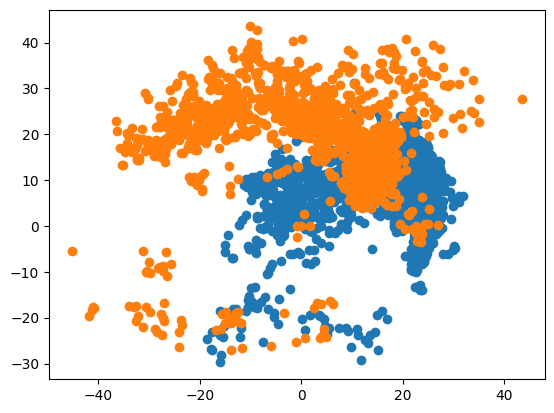

In [127]:
kk = 2
oo = head_per_shot[kk]
ee = gazes_per_shot[kk]
plt.scatter(oo[:, 0], oo[:, 1])
plt.scatter(ee[:, 0], ee[:, 1])

## output one file

In [107]:
for j in range(0, len(auds)):
    output_audio_onscreen_path = os.path.join(*[output_folder, "audio", file_name+"_{}_{}.wav".format(j, 0)]) 
    output_audio_offscreen_path = os.path.join(*[output_folder, "audio", file_name+"_{}_{}.wav".format(j, 1)]) 
    output_gaze_path = os.path.join(*[output_folder, "gaze", file_name+"_{}.pkl".format(j)]) 
    output_head_path = os.path.join(*[output_folder, "head", file_name+"_{}.pkl".format(j)]) 
    output_blinks_path = os.path.join(*[output_folder, "blinks", file_name+"_{}.pkl".format(j)]) 
    # annotation files
    pkl.dump(gazes_per_shot[j], open(output_gaze_path,  "wb"))
    pkl.dump(head_per_shot[j], open(output_head_path,  "wb"))
    pkl.dump(blink_per_shot[j], open(output_blinks_path,  "wb"))
    sf.write(output_audio_onscreen_path, auds[j][0], sr)
    sf.write(output_audio_offscreen_path, auds[j][1], sr)